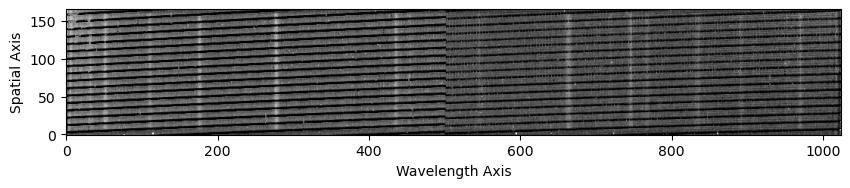

In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from lmfit import Model
from lmfit.models import PolynomialModel, QuadraticModel, LinearModel, ConstantModel
from lmfit import minimize, Parameters, fit_report

import os
import warnings
warnings.filterwarnings('ignore')

# path joining version for other paths
notebook_path = os.path.abspath('/Users/RuoyanWang/Documents/LEICESTER/h3p/code/')
filepath = os.path.join(os.path.dirname(notebook_path), '02jun17/spec/')

# count number of fits files in folder
filesize = len([name for name in os.listdir(filepath) if os.path.isfile(os.path.join(filepath, name))])


# define normalization function
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# define guassian function, credit to pen and pants IDL's Gaussfit in Python
def gaussian_fit(x, a0, a1, a2, a3, a4, a5): 
    """
    x = data array
    a0 = height of guassian
    a1 = pixel position of Gaussian peak
    a2 = width of Gaussian
    a3 = constant term
    a4 = linear term
    a5 = quadratic term
    
    note: fwhm = a2 * np.sqrt(2 * np.log(2)) * 2
    """
    z = (x - a1) / a2
    y = a0 * np.exp(-z**2 / a2) + a3 + a4 * x + a5 * x**2
    return y

# load waverange
waverange = fits.open(filepath + 'order32/' + 'waverange.fits', ignore_missing_end=True)[0].data

# load skylines
skylines60m = fits.open(filepath + 'order32/skylines60m_order32.fits', ignore_missing_end=True)[0].data
skylines60p = fits.open(filepath + 'order32/skylines60p_order32.fits', ignore_missing_end=True)[0].data
skylines60p_shifted = fits.open(filepath + 'order32/skylines60p_shifted_order32.fits', ignore_missing_end=True)[0].data

# spat_lower = 220
# spat_upper = 320

plt.figure(figsize=(10,2))
plt.imshow(skylines60m, cmap='gist_gray')
# plt.imshow(skylines, aspect='auto', extent=[waverange[0], waverange[-1], 0, 165], cmap='gist_gray')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 1024
    # variables        = 2
    chi-square         = 4.8537e-12
    reduced chi-square = 4.7492e-15
    Akaike info crit   = -33770.3461
    Bayesian info crit = -33760.4832
    R-squared          = 1.00000000
[[Variables]]
    slope:      3.3040e-05 +/- 7.2853e-12 (0.00%) (init = 3.304e-05)
    intercept:  2.38226635 +/- 4.3040e-09 (0.00%) (init = 2.382266)
[[Correlations]] (unreported correlations are < 0.250)
    C(slope, intercept) = -0.8658


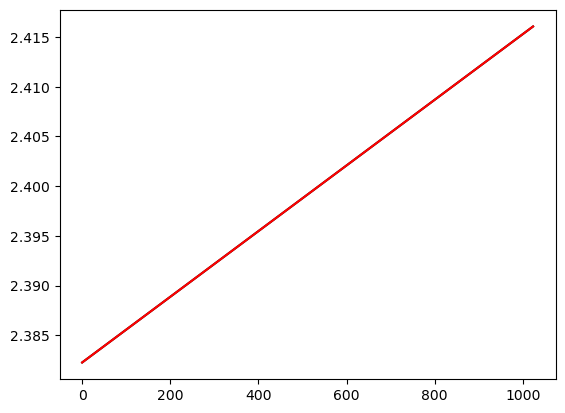

In [28]:
waveaxis = np.linspace(0, 1023, 1024)

mod = LinearModel()

pars = mod.guess(waverange, x=waveaxis)
out = mod.fit(waverange, pars, x=waveaxis)

print(out.fit_report(min_correl=0.25))

m = out.params['slope'].value
y0 = out.params['intercept'].value

wave_best_fit = m*waveaxis + y0

plt.figure()
plt.plot(waveaxis, waverange,'k', label = 'original')
plt.plot(waveaxis, wave_best_fit, 'r', label = 'best fit')

[[Model]]
    Model(gaussian_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 56
    # data points      = 130
    # variables        = 6
    chi-square         = 2654.70010
    reduced chi-square = 21.4088718
    Akaike info crit   = 404.151828
    Bayesian info crit = 421.357035
    R-squared          = 0.87523234
[[Variables]]
    a0:  76.1028639 +/- 3.33657217 (4.38%) (init = 79)
    a1:  2.38815059 +/- 1.9566e-06 (0.00%) (init = 2.3882)
    a2:  0.00142050 +/- 4.7982e-05 (3.38%) (init = 0.003)
    a3: -6098095.55 +/- 4835119.34 (79.29%) (init = 0)
    a4:  5108753.98 +/- 4049031.74 (79.26%) (init = 0)
    a5: -1069979.41 +/- 847686.243 (79.22%) (init = 0)
[[Correlations]] (unreported correlations are < 0.250)
    C(a4, a5) = -1.0000
    C(a3, a4) = -1.0000
    C(a3, a5) = +1.0000
    C(a0, a2) = -0.5626
    C(a0, a1) = +0.3464
    C(a1, a2) = -0.2895
2.388150590958557


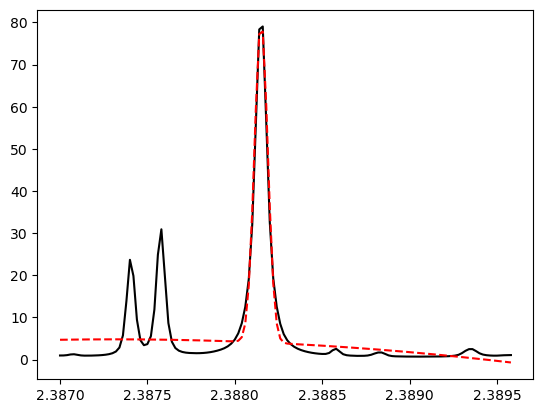

In [3]:
gemini_df = pd.read_csv('mk_skybg_zm_10_10_ph.dat', sep='\s+', header=None)
gemini_array = gemini_df.to_numpy()

wavelength = (gemini_array[74350:74480,0])/1000#[gemini_array[60500:62500,1]>0.5]
count = gemini_array[74350:74480,1]#[gemini_array[60500:62500,1]>0.5]

plt.figure()
plt.plot(wavelength, count, 'k', label='original')

# create lmfit model with defined gaussian
g1_model = Model(gaussian_fit)

# create parameters and add initial guess
g1_params = g1_model.make_params()
g1_params.add('a0', value=79, min=76, max=85)
g1_params.add('a1', value=2.3882)
g1_params.add('a2', value=0.003)
g1_params.add('a3', value=0)
g1_params.add('a4', value=0)
g1_params.add('a5', value=0)

g1_result = g1_model.fit(count, g1_params, x=wavelength)
# try:
#     g1_result = g1_model.fit(count, g1_params, x=wavelength)
# except:
#     pass

print(g1_result.fit_report(min_correl=0.25))

plt.plot(wavelength, g1_result.best_fit, 'r--', label='g1 best fit')
#plt.xlim(2.123,2.1235)

print(g1_result.params['a1'].value)

[[Model]]
    Model(gaussian_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 132
    # data points      = 130
    # variables        = 6
    chi-square         = 9128.98828
    reduced chi-square = 73.6208732
    Akaike info crit   = 564.717842
    Bayesian info crit = 581.923048
    R-squared          = 0.72956410
[[Variables]]
    a0:  92.0000254 +/- 6.32730345 (6.88%) (init = 97)
    a1:  2.40697823 +/- 2.9726e-06 (0.00%) (init = 2.407)
    a2:  0.00138474 +/- 7.3119e-05 (5.28%) (init = 0.003)
    a3:  63.5658015 +/- 8670693.46 (13640500.48%) (init = 0)
    a4:  0.80687644 +/- 7202509.65 (892640969.62%) (init = 0)
    a5: -10.3056534 +/- 1495732.19 (14513705.55%) (init = 0)
[[Correlations]] (unreported correlations are < 0.250)
    C(a4, a5) = -1.0000
    C(a3, a4) = -1.0000
    C(a3, a5) = +1.0000
    C(a0, a2) = -0.5775
    C(a0, a1) = +0.3606
    C(a1, a2) = -0.3062
2.4069782258240044


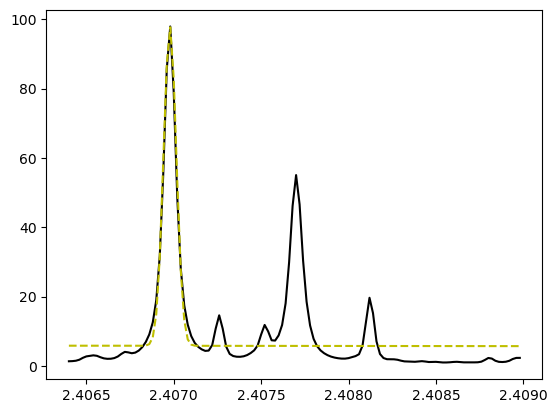

In [4]:
gemini_df = pd.read_csv('mk_skybg_zm_10_10_ph.dat', sep='\s+', header=None)
gemini_array = gemini_df.to_numpy()

wavelength = (gemini_array[75320:75450,0])/1000#[gemini_array[60500:62500,1]>0.5]
count = gemini_array[75320:75450,1]#[gemini_array[60500:62500,1]>0.5]
# count[count<30]=30

plt.figure()
plt.plot(wavelength, count, 'k', label='original')

# create lmfit model with defined gaussian
g2_model = Model(gaussian_fit)
#print('parameter names: {}'.format(g2model.param_names))
#print('independent variables: {}'.format(g2model.independent_vars))


# create parameters and add initial guess
g2_params = g2_model.make_params()
g2_params.add('a0', value=97, min=92)
g2_params.add('a1', value=2.4070)
g2_params.add('a2', value=0.003)
g2_params.add('a3', value=0)
g2_params.add('a4', value=0)
g2_params.add('a5', value=0)

try:
    g2_result = g2_model.fit(count, g2_params, x=wavelength)
except:
    pass

print(g2_result.fit_report(min_correl=0.25))

plt.plot(wavelength, g2_result.best_fit, 'y--', label='g2 best fit')
#plt.xlim(2.1246,2.1252)

print(g2_result.params['a1'].value)

[[Model]]
    Model(gaussian_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 78
    # data points      = 180
    # variables        = 6
    chi-square         = 2563.68252
    reduced chi-square = 14.7338076
    Akaike info crit   = 490.123765
    Bayesian info crit = 509.281506
    R-squared          = 0.93410796
[[Variables]]
    a0:  99.6546223 +/- 2.46145286 (2.47%) (init = 105)
    a1:  2.41433340 +/- 1.1830e-06 (0.00%) (init = 2.4143)
    a2:  0.00151705 +/- 2.9264e-05 (1.93%) (init = 0.003)
    a3: -4943266.21 +/- 1765009.18 (35.71%) (init = 0)
    a4:  4095442.10 +/- 1462430.33 (35.71%) (init = 0)
    a5: -848256.445 +/- 302930.740 (35.71%) (init = 0)
[[Correlations]] (unreported correlations are < 0.250)
    C(a3, a4) = -1.0000
    C(a4, a5) = -1.0000
    C(a3, a5) = +1.0000
    C(a0, a2) = -0.5353
2.414333399562101


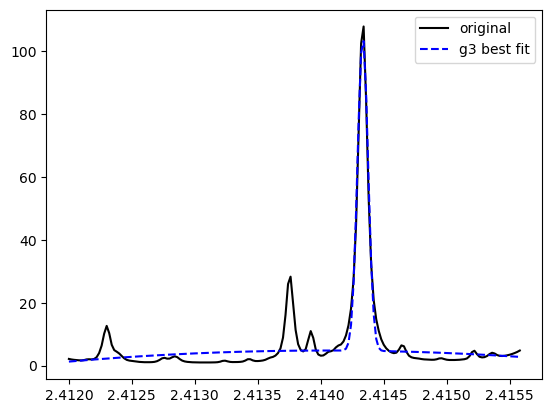

In [5]:
gemini_df = pd.read_csv('mk_skybg_zm_10_10_ph.dat', sep='\s+', header=None)
gemini_array = gemini_df.to_numpy()

wavelength = (gemini_array[75600:75780,0]/1000)#[gemini_array[60500:62500,1]>0.5]
count = gemini_array[75600:75780,1]#[gemini_array[60500:62500,1]>0.5]

plt.figure()
plt.plot(wavelength, count, 'k', label='original')

# create lmfit model with defined gaussian
g3_model = Model(gaussian_fit)

# create parameters and add initial guess
g3_params = g3_model.make_params()
g3_params.add('a0', value=105)
g3_params.add('a1', value=2.4143, min=2.41)
g3_params.add('a2', value=0.003)
g3_params.add('a3', value=0)
g3_params.add('a4', value=0)
g3_params.add('a5', value=0)

try:
    g3_result = g3_model.fit(count, g3_params, x=wavelength)
except:
    pass

print(g3_result.fit_report(min_correl=0.25))

plt.plot(wavelength, g3_result.best_fit, 'b--', label='g3 best fit')
plt.legend()
#plt.xlim(2.1315,2.133)

print(g3_result.params['a1'].value)

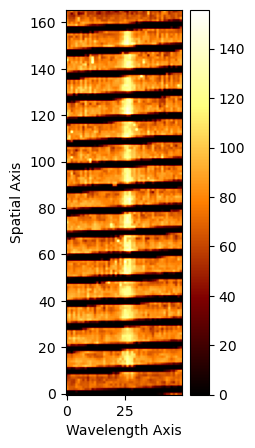

In [41]:
a = np.delete(skylines60m, np.s_[200:], 1)
b = np.delete(a, np.s_[:150], 1)
# b[b<70]=70
# b[b>120]=120

plt.figure(figsize=(2,5))
# plt.imshow(c, aspect='auto', extent=[waverange[120], waverange[179], 364, 225], cmap='afmhot')
plt.imshow(b, cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()
plt.colorbar()

In [42]:
for i in range(len(b)):
    if i%5 == 0 and i%10 != 0 and i!= 5:
        print ('i = ' +str(i))
#         plt.figure()
#         plt.plot(b[i])
#         plt.title('i = ' +str(i))

i = 15
i = 25
i = 35
i = 45
i = 55
i = 65
i = 75
i = 85
i = 95
i = 105
i = 115
i = 125
i = 135
i = 145
i = 155
i = 165


In [50]:
a = np.delete(skylines60m, np.s_[200:], 1)
b = np.delete(a, np.s_[:150], 1)
b = normalize(b)
waveaxis = np.linspace(0, np.size(b, 1)-1, np.size(b, 1))
# waveaxis = waverange[150:200]*100000

upper_skyline = 166
lower_skyline = 0

sky1_a1 = []
sky1_a1_pixel = []

for i in range(lower_skyline, upper_skyline):           
    if i%5 == 0 and i%10 != 0 and i!= 5:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=0.7)
        # sky1_params.add('a1', value=238810)
        sky1_params.add('a1', value=25)
        sky1_params.add('a2', value=1)
        sky1_params.add('a3', value=0)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(b[i], sky1_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, b[i])
            plt.plot(waveaxis, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1.append(sky1_fit_result.params['a1'].value)
# sky1_a1 = np.array(sky1_a1)/100000
sky1_a1 = np.array(sky1_a1)+150

In [51]:
sky1_a1

array([176.0981178 , 176.080742  , 176.17429443, 175.6495776 ,
       176.39790885, 176.00071895, 175.90776874, 176.27301089,
       175.98055893, 176.69787281, 176.05371825, 176.09891041,
       176.05885847, 176.53331396, 176.01762931, 175.54314073])

[[Model]]
    Model(constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 16
    # variables        = 1
    chi-square         = 1.25438684
    reduced chi-square = 0.08362579
    Akaike info crit   = -38.7350695
    Bayesian info crit = -37.9624807
    R-squared          = 0.00000000
[[Variables]]
    c:  176.097884 +/- 0.07229531 (0.04%) (init = 176.0979)


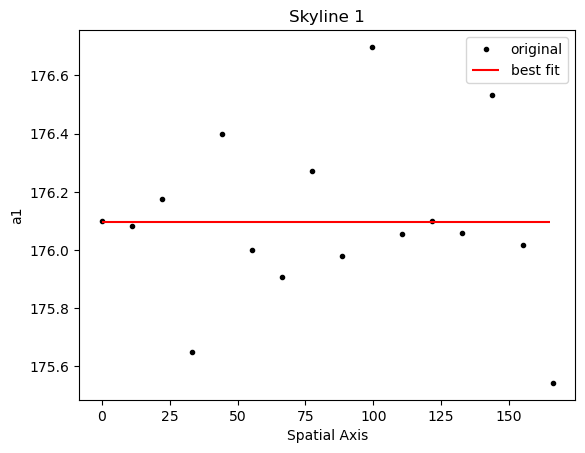

In [52]:
sky1_spat = np.linspace(lower_skyline, upper_skyline, len(sky1_a1))

x = sky1_spat
y = sky1_a1

mod = ConstantModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

sky1_spat_all = np.linspace(0, 165, 166)
# sky1_slope = out.params['slope'].value
# sky1_intercept = out.params['intercept'].value
sky1_c = out.params['c'].value
sky1_a1_best_fit = sky1_c

plt.plot(x, y, '.k', label = 'original')
plt.hlines(sky1_a1_best_fit, xmin=sky1_spat_all[0], xmax=sky1_spat_all[-1], color='r', label='best fit')
# plt.hlines(g1_result.params['a1'].value, xmin=sky1_spat_all[0], xmax=sky1_spat_all[-1], color='b', label='g1')
plt.title('Skyline 1')
plt.xlabel('Spatial Axis')
plt.ylabel('a1')
plt.legend()

In [61]:
g1_result.params['a1'].value - (m * sky1_a1_best_fit + y0)

6.596552705806502e-05

In [96]:
g1_result.params['a1'].value - sky1_a1_best_fit

6.46977834275475e-05

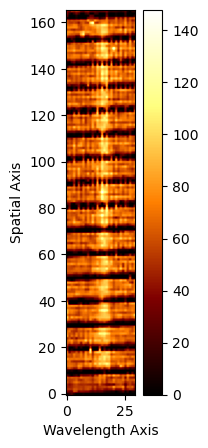

In [8]:
c = np.delete(skylines60m, np.s_[760:], 1)
d = np.delete(c, np.s_[:730], 1)

plt.figure(figsize=(2,5))
# plt.imshow(c, aspect='auto', extent=[waverange[120], waverange[179], 364, 225], cmap='afmhot')
plt.imshow(d, cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()
plt.colorbar()

i = 15
i = 25
i = 35
i = 45
i = 55
i = 65
i = 75
i = 85
i = 95
i = 105
i = 115
i = 125
i = 135
i = 145
i = 155


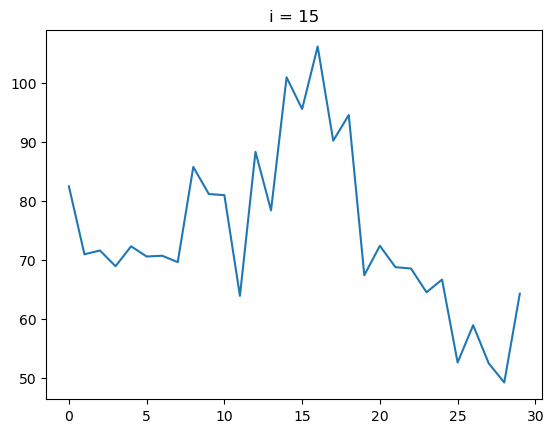

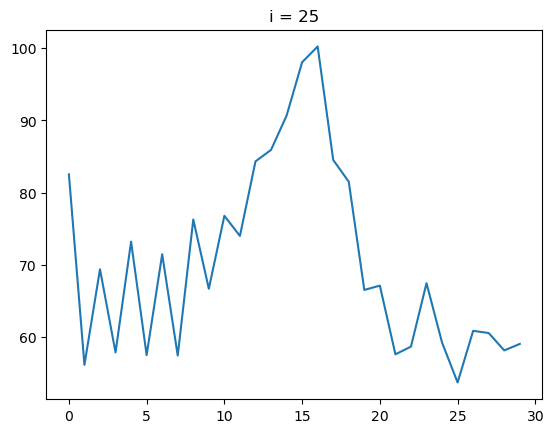

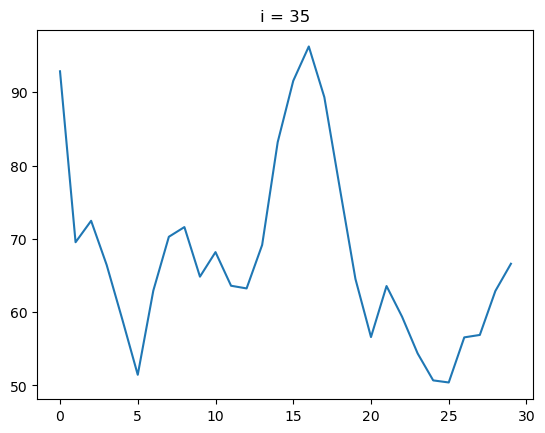

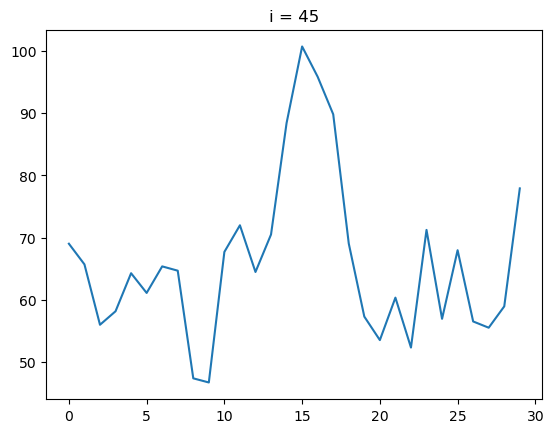

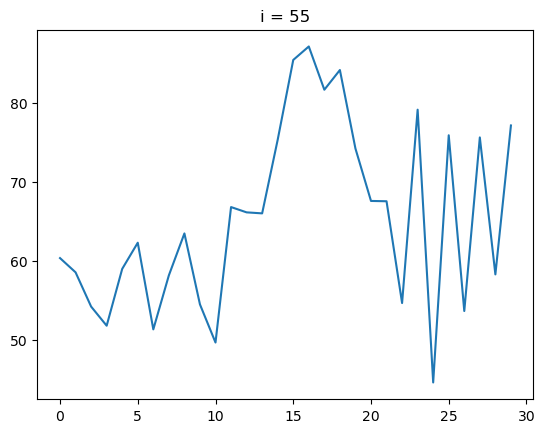

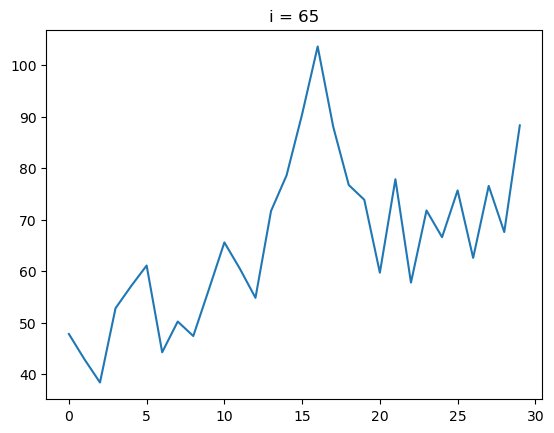

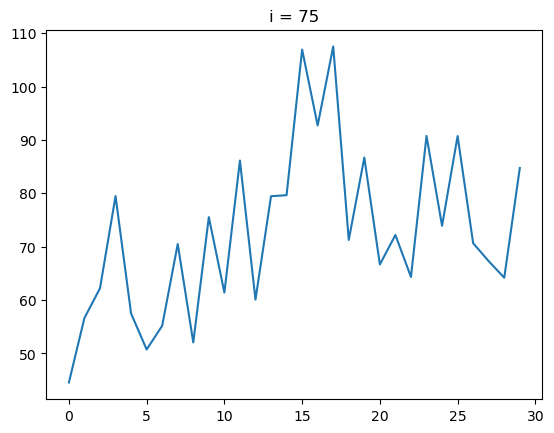

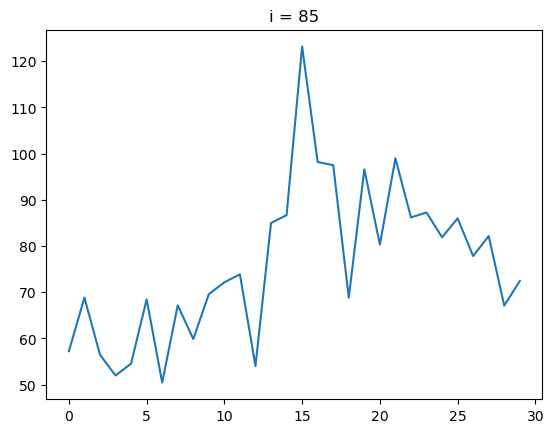

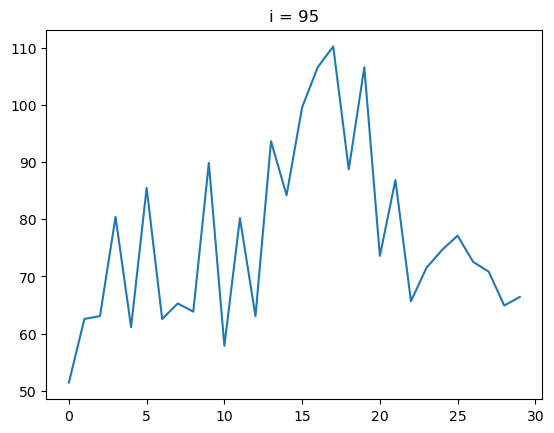

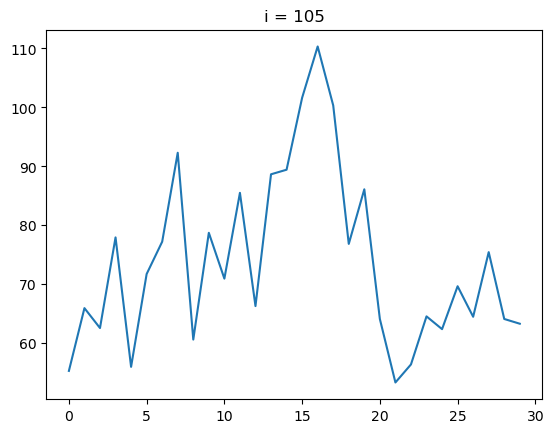

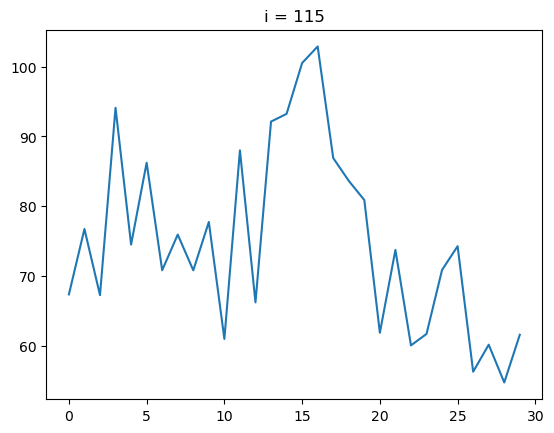

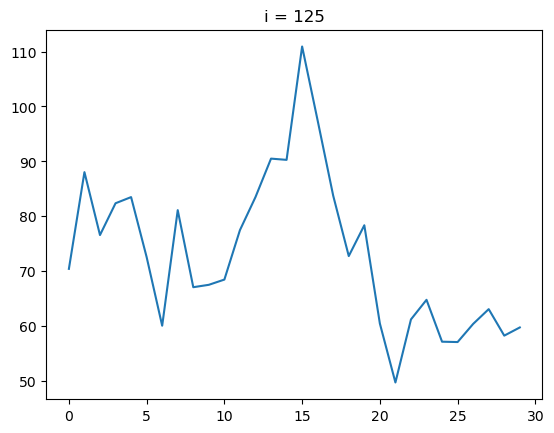

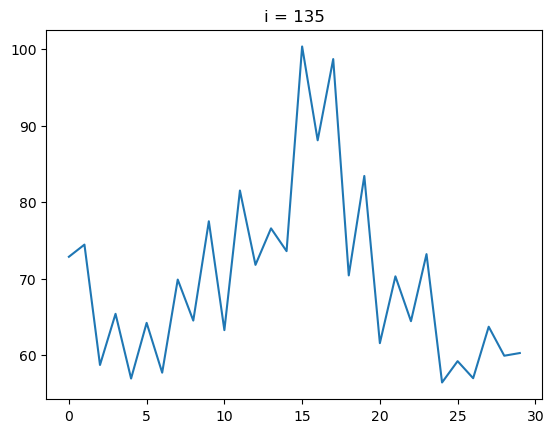

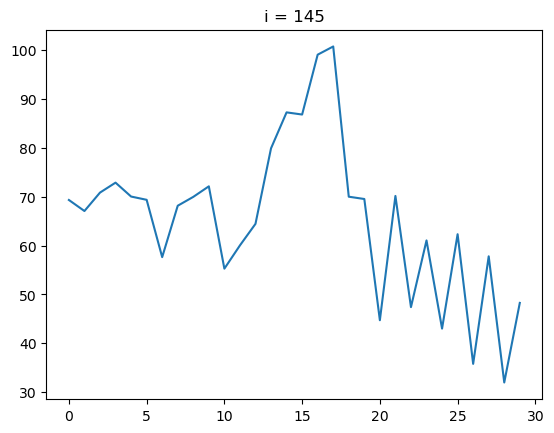

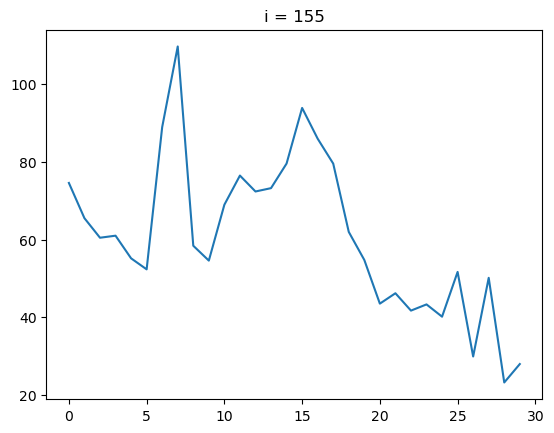

In [9]:
# for i in range(80):
#     if i%10 == 0 and i != 0:
#         print ('i = ' +str(i))
#         plt.figure()
#         plt.plot(d[i])
#         plt.title('i = ' +str(i))
        
for i in range(0, 160):
    if i%5 == 0 and i%2 !=0 and i!=5:
        print ('i = ' +str(i))
        plt.figure()
        plt.plot(d[i])
        plt.title('i = ' +str(i))

Error occured at i=45


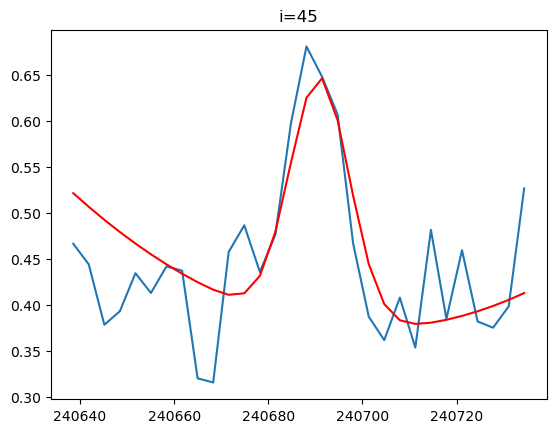

In [10]:
c = np.delete(skylines60m, np.s_[760:], 1)
d = np.delete(c, np.s_[:730], 1)
d = normalize(d)
#waveaxis = np.linspace(0, np.size(e, 1), np.size(e, 1))
waveaxis = waverange[730:760]*100000

upper_skyline = 160
lower_skyline = 0

sky2_a1 = []

for i in range(lower_skyline, upper_skyline):           
    if i%5 == 0 and i%10 != 0 and i!= 5:
        # create lmfit model with defined gaussian
        sky2_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky2_params = sky2_model.make_params()
        sky2_params.add('a0', value=0.5)
        sky2_params.add('a1', value=240698)
        sky2_params.add('a2', value=5)
        sky2_params.add('a3', value=0.3)
        sky2_params.add('a4', value=0)
        sky2_params.add('a5', value=0)
    
        try:
            sky2_fit_result = sky2_model.fit(d[i], sky2_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky2_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, d[i])
            plt.plot(waveaxis, sky2_fit_result.best_fit, 'r-', label='best fit')
            
        sky2_a1.append(sky2_fit_result.params['a1'].value)
sky2_a1 = np.array(sky2_a1)/100000

[[Model]]
    Model(constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 15
    # variables        = 1
    chi-square         = 5.1491e-09
    reduced chi-square = 3.6779e-10
    Akaike info crit   = -324.887362
    Bayesian info crit = -324.179312
    R-squared          = 0.00000000
[[Variables]]
    c:  2.40690780 +/- 4.9517e-06 (0.00%) (init = 2.406908)


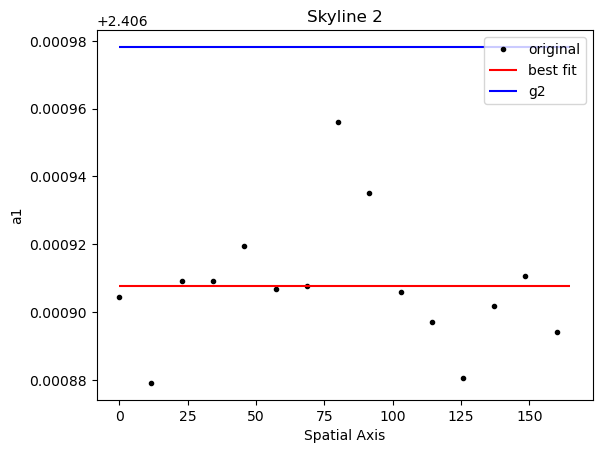

In [11]:
sky2_spat = np.linspace(lower_skyline, upper_skyline, len(sky2_a1))

x = sky2_spat
y = sky2_a1

mod = ConstantModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

sky2_spat_all = np.linspace(0, 165, 166)
# sky2_slope = out.params['slope'].value
# sky2_intercept = out.params['intercept'].value
sky2_c = out.params['c'].value
sky2_a1_best_fit = sky2_c

plt.plot(x, y, '.k', label = 'original')
plt.hlines(sky2_a1_best_fit, xmin=sky2_spat_all[0], xmax=sky2_spat_all[-1], color='r', label='best fit')
plt.hlines(g2_result.params['a1'].value, xmin=sky2_spat_all[0], xmax=sky2_spat_all[-1], color='b', label='g2')
plt.title('Skyline 2')
plt.xlabel('Spatial Axis')
plt.ylabel('a1')
plt.legend()

In [12]:
g2_result.params['a1'].value - sky2_a1_best_fit

7.042217103414572e-05

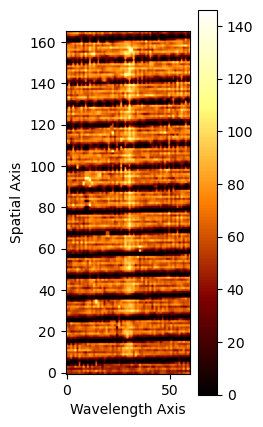

In [13]:
e = np.delete(skylines60m, np.s_[1000:], 1)
f = np.delete(e, np.s_[:940], 1)

plt.figure(figsize=(2,5))
# plt.imshow(c, aspect='auto', extent=[waverange[120], waverange[179], 364, 225], cmap='afmhot')
plt.imshow(f, cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()
plt.colorbar()

In [14]:
e = np.delete(skylines60m, np.s_[1000:], 1)
f = np.delete(e, np.s_[:940], 1)
f = normalize(f)
#waveaxis = np.linspace(0, np.size(e, 1), np.size(e, 1))
waveaxis = waverange[940:1000]*100000

upper_skyline = 160
lower_skyline = 0

sky3_a1 = []

for i in range(80):           
    if i%10 == 0 and i != 0:
        # create lmfit model with defined gaussian
        sky3_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky3_params = sky3_model.make_params()
        sky3_params.add('a0', value=0.5)
        sky3_params.add('a1', value=241433)
        sky3_params.add('a2', value=5)
        sky3_params.add('a3', value=0.3)
        sky3_params.add('a4', value=0)
        sky3_params.add('a5', value=0)
    
        try:
            sky3_fit_result = sky3_model.fit(f[i], sky3_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky3_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, f[i])
            plt.plot(waveaxis, sky3_fit_result.best_fit, 'r-', label='best fit')
            
        sky3_a1.append(sky3_fit_result.params['a1'].value)
        
for i in range(85, 160):           
    if i%5 == 0 and i%2 !=0:
        # create lmfit model with defined gaussian
        sky3_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky3_params = sky3_model.make_params()
        sky3_params.add('a0', value=0.5)
        sky3_params.add('a1', value=241433)
        sky3_params.add('a2', value=5)
        sky3_params.add('a3', value=0.3)
        sky3_params.add('a4', value=0)
        sky3_params.add('a5', value=0)
    
        try:
            sky3_fit_result = sky3_model.fit(f[i], sky3_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky3_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, f[i])
            plt.plot(waveaxis, sky3_fit_result.best_fit, 'r-', label='best fit')
            
        sky3_a1.append(sky3_fit_result.params['a1'].value)
        
sky3_a1 = np.array(sky3_a1)/100000

[[Model]]
    Model(constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 15
    # variables        = 1
    chi-square         = 4.2285e-09
    reduced chi-square = 3.0204e-10
    Akaike info crit   = -327.841950
    Bayesian info crit = -327.133900
    R-squared          = 0.00000000
[[Variables]]
    c:  2.41430800 +/- 4.4873e-06 (0.00%) (init = 2.414308)


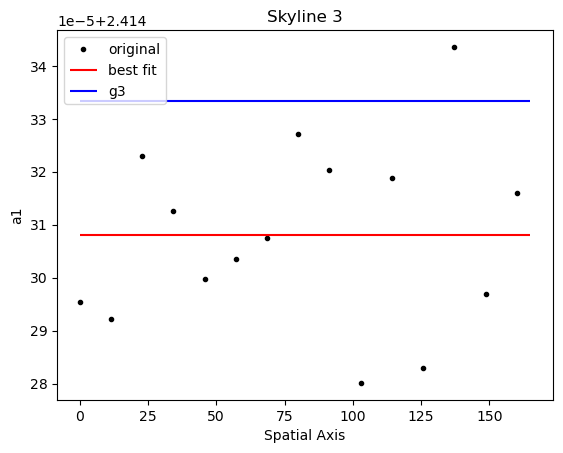

In [15]:
sky3_spat = np.linspace(lower_skyline, upper_skyline, len(sky3_a1))

x = sky3_spat
y = sky3_a1

mod = ConstantModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

sky3_spat_all = np.linspace(0, 165, 166)
# sky3_slope = out.params['slope'].value
# sky3_intercept = out.params['intercept'].value
sky3_c = out.params['c'].value
sky3_a1_best_fit = sky3_c

plt.plot(x, y, '.k', label = 'original')
plt.hlines(sky3_a1_best_fit, xmin=sky3_spat_all[0], xmax=sky3_spat_all[-1], color='r', label='best fit')
plt.hlines(g3_result.params['a1'].value, xmin=sky3_spat_all[0], xmax=sky3_spat_all[-1], color='b', label='g3')
plt.title('Skyline 3')
plt.xlabel('Spatial Axis')
plt.ylabel('a1')
plt.legend()

In [16]:
g3_result.params['a1'].value - sky3_a1_best_fit

2.5402816191011368e-05

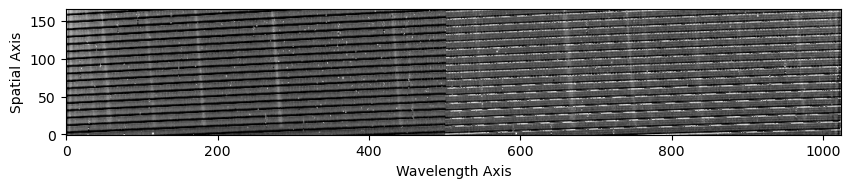

In [17]:
plt.figure(figsize=(10,2))
# plt.imshow(skylines, aspect='auto', extent=[0, 1089, 364, 225], cmap='gist_gray')
plt.imshow(skylines60p, cmap='gist_gray')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()

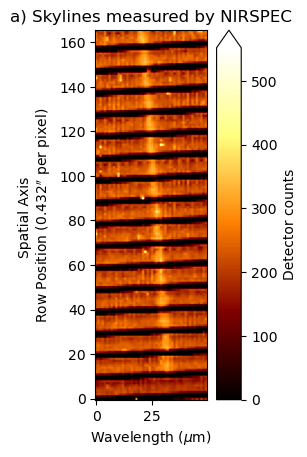

In [18]:
a = np.delete(skylines60p, np.s_[200:], 1)
b = np.delete(a, np.s_[:150], 1)

plt.figure()
plt.imshow(b, cmap='afmhot')
plt.xlabel(r'Wavelength ($\mu$m)')
plt.ylabel('Spatial Axis \nRow Position (0.432$^{\prime\prime}$ per pixel)')
plt.title('a) Skylines measured by NIRSPEC')
plt.gca().invert_yaxis()
plt.colorbar(extend='max', aspect=15, pad=0.02, label='Detector counts')

i = 15
i = 25
i = 35
i = 45
i = 55
i = 65
i = 75
i = 85
i = 95
i = 105
i = 115
i = 125
i = 135
i = 145
i = 155
i = 165


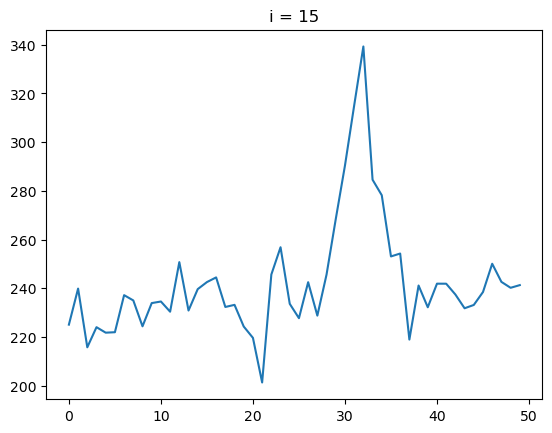

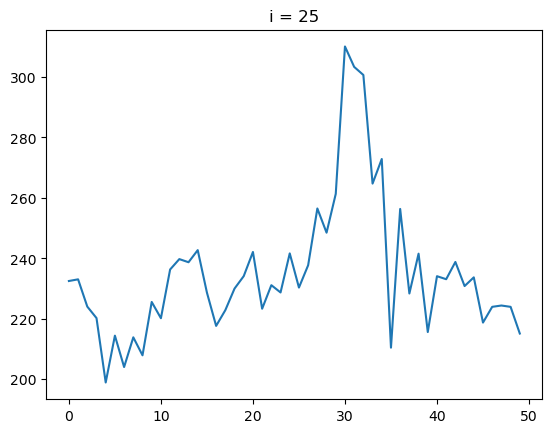

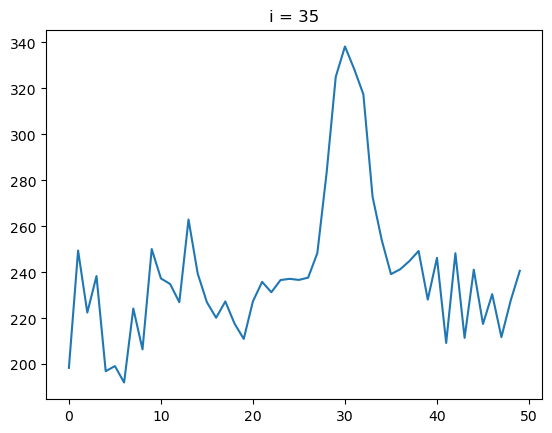

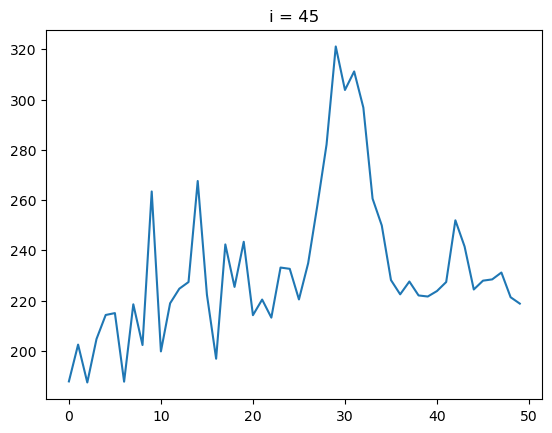

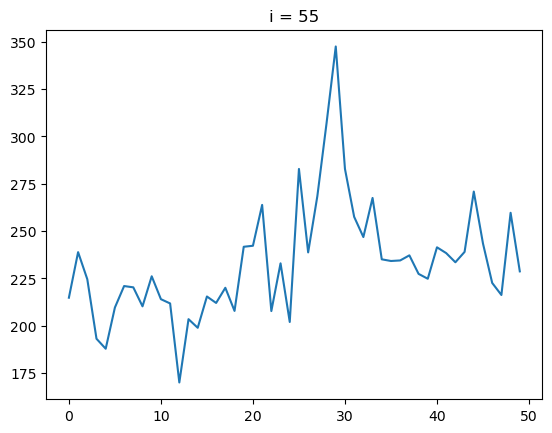

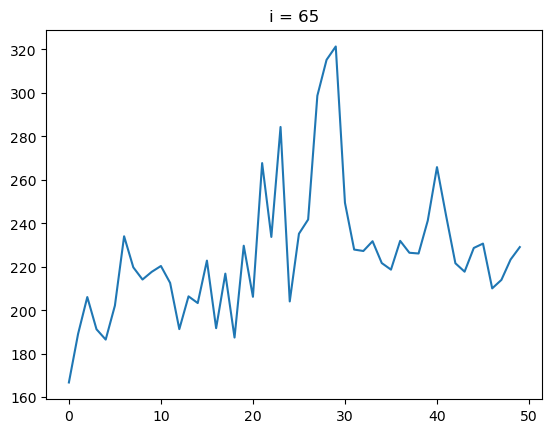

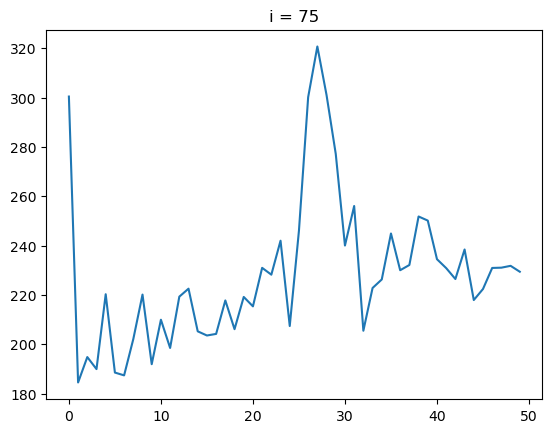

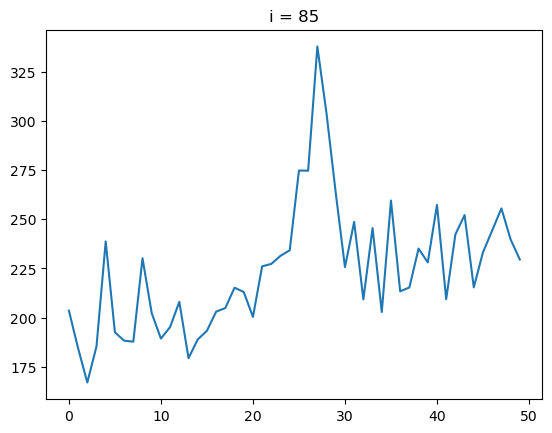

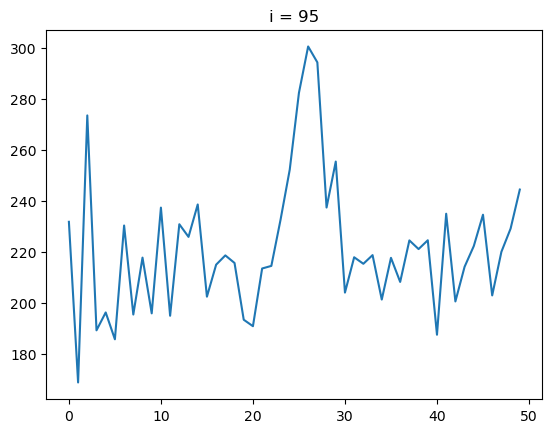

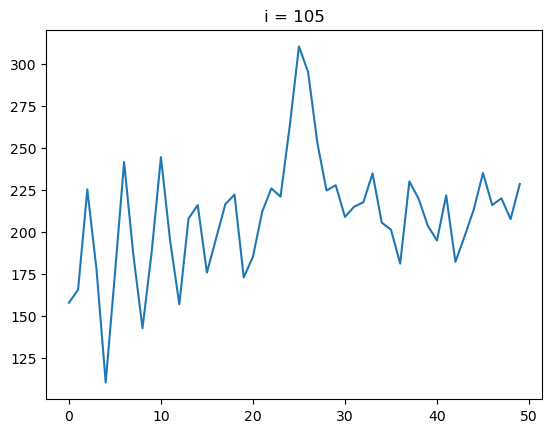

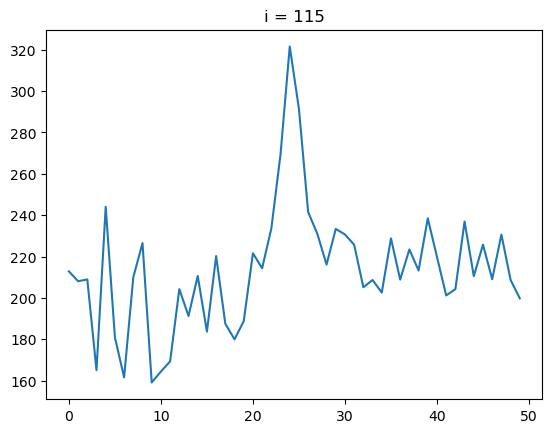

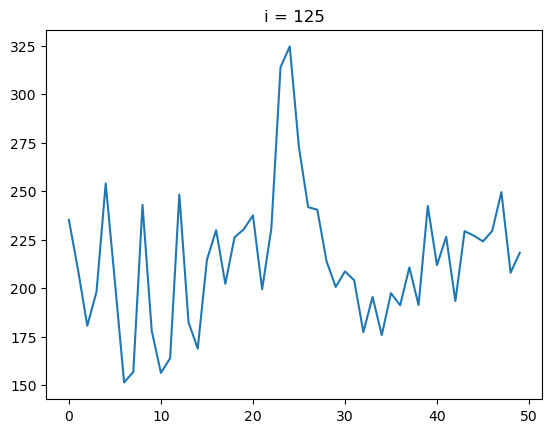

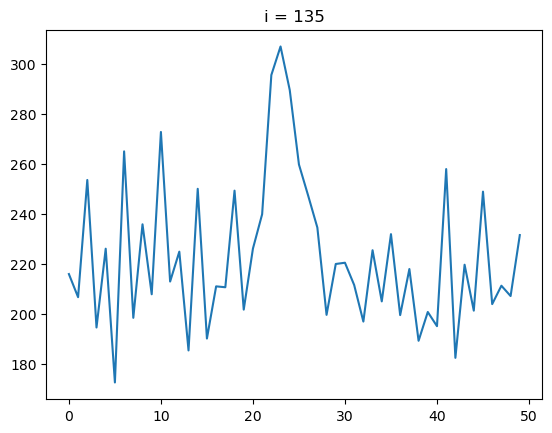

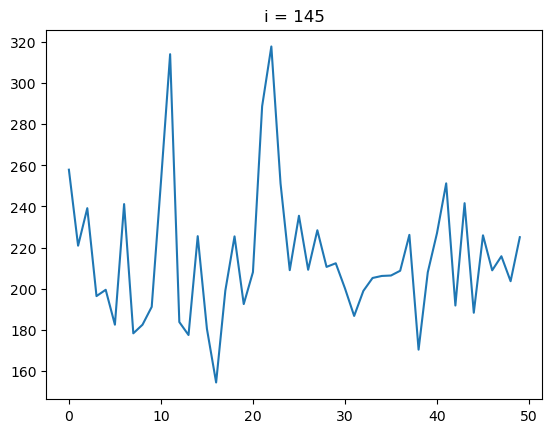

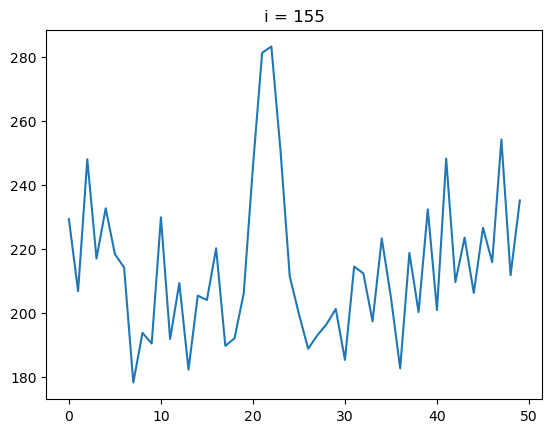

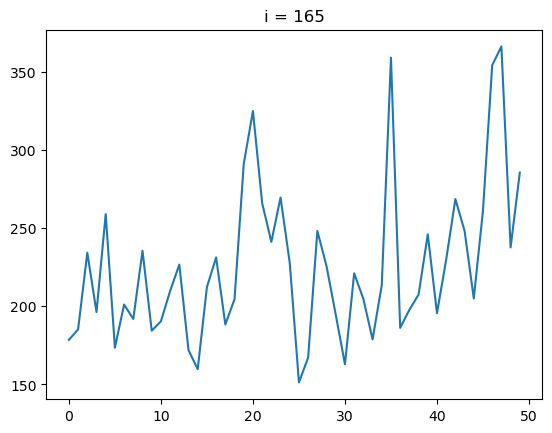

In [19]:
for i in range(len(b)):
    if i%5 == 0 and i%10 != 0 and i!= 5:
        print ('i = ' +str(i))
        plt.figure()
        plt.plot(b[i])
        plt.title('i = ' +str(i))

In [21]:
a = np.delete(skylines60p, np.s_[200:], 1)
b = np.delete(a, np.s_[:150], 1)
b = normalize(b)

waveaxis = np.linspace(0 ,np.size(b,1)-1, np.size(b,1))
# waveaxis = waverange[110:170]*100000

upper_skyline = 165
lower_skyline = 0

sky1_a1 = []

for i in range(lower_skyline, upper_skyline):
    if i%5 == 0 and i%10 != 0 and i!= 5 and i<= 75:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=0.7)
        sky1_params.add('a1', value=30)
        sky1_params.add('a2', value=1)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(b[i], sky1_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, b[i])
            plt.plot(waveaxis, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1.append(sky1_fit_result.params['a1'].value)
        
    if i%5 == 0 and i%10 != 0 and i!= 5 and i>= 75 and i<=135:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=0.7)
        sky1_params.add('a1', value=25)
        sky1_params.add('a2', value=1)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(b[i], sky1_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, b[i])
            plt.plot(waveaxis, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1.append(sky1_fit_result.params['a1'].value)
        
    if i%5 == 0 and i%10 != 0 and i!= 5 and i>= 135:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=0.7)
        sky1_params.add('a1', value=23)
        sky1_params.add('a2', value=1)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(b[i], sky1_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, b[i])
            plt.plot(waveaxis, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1.append(sky1_fit_result.params['a1'].value)
sky1_a1 = np.array(sky1_a1)+150

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 17
    # variables        = 2
    chi-square         = 1.48843011
    reduced chi-square = 0.09922867
    Akaike info crit   = -37.4033538
    Bayesian info crit = -35.7369271
    R-squared          = 0.99102904
[[Variables]]
    slope:     -0.06771526 +/- 0.00166348 (2.46%) (init = -0.06771526)
    intercept:  182.619172 +/- 0.16808030 (0.09%) (init = 182.6192)
[[Correlations]] (unreported correlations are < 0.250)
    C(slope, intercept) = -0.8907


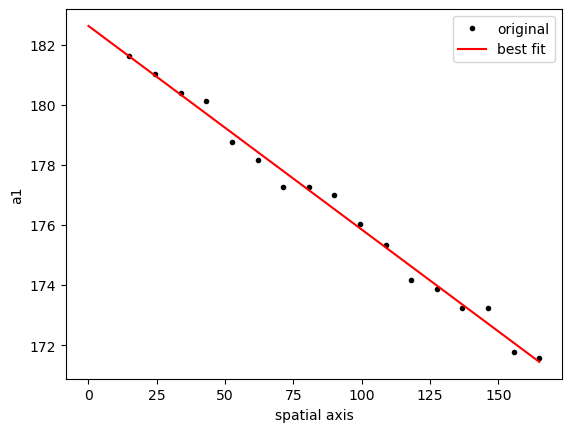

In [23]:
sky1_spat = np.linspace(15, 165, len(sky1_a1))
x = sky1_spat
y = sky1_a1

mod = LinearModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

slope = out.params['slope'].value
intercept = out.params['intercept'].value

sky1_spat_all = np.linspace(0, 165, 166)
sky1_a1_best_fit = slope*sky1_spat_all + intercept

plt.figure()
plt.plot(sky1_spat, sky1_a1,'.k', label = 'original')
plt.plot(sky1_spat_all, sky1_a1_best_fit, 'r', label = 'best fit')
plt.xlabel('spatial axis')
plt.ylabel('a1')
plt.ticklabel_format(useOffset=False)
plt.legend()

In [24]:
g1_result.params['a1'].value, g2_result.params['a1'].value, g3_result.params['a1'].value

(2.388150590958557, 2.4069782258240044, 2.414333399562101)

In [34]:
(g1_result.params['a1'].value-y0)/m

178.09441911905435

In [30]:
sky1_pixel_offset_order32 = 176.097841 - sky1_a1_best_fit
# np.savetxt('sky1_pixel_offset_order32.txt', sky1_pixel_offset_order32)
sky1_pixel_offset_order32

array([-6.5213305 , -6.45361524, -6.38589998, -6.31818472, -6.25046946,
       -6.1827542 , -6.11503893, -6.04732367, -5.97960841, -5.91189315,
       -5.84417789, -5.77646263, -5.70874737, -5.64103211, -5.57331684,
       -5.50560158, -5.43788632, -5.37017106, -5.3024558 , -5.23474054,
       -5.16702528, -5.09931002, -5.03159475, -4.96387949, -4.89616423,
       -4.82844897, -4.76073371, -4.69301845, -4.62530319, -4.55758793,
       -4.48987266, -4.4221574 , -4.35444214, -4.28672688, -4.21901162,
       -4.15129636, -4.0835811 , -4.01586584, -3.94815057, -3.88043531,
       -3.81272005, -3.74500479, -3.67728953, -3.60957427, -3.54185901,
       -3.47414375, -3.40642848, -3.33871322, -3.27099796, -3.2032827 ,
       -3.13556744, -3.06785218, -3.00013692, -2.93242166, -2.86470639,
       -2.79699113, -2.72927587, -2.66156061, -2.59384535, -2.52613009,
       -2.45841483, -2.39069957, -2.3229843 , -2.25526904, -2.18755378,
       -2.11983852, -2.05212326, -1.984408  , -1.91669274, -1.84

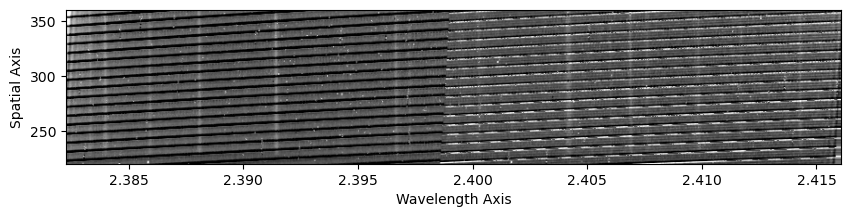

In [62]:
plt.figure(figsize=(10,2))
plt.imshow(skylines60p_shifted, aspect='auto', extent=[waverange[0], waverange[-1], 360, 220], cmap='gist_gray')
# plt.imshow(skylines, cmap='gist_gray')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()

[[Model]]
    Model(gaussian_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 56
    # data points      = 130
    # variables        = 6
    chi-square         = 2654.70010
    reduced chi-square = 21.4088718
    Akaike info crit   = 404.151828
    Bayesian info crit = 421.357035
    R-squared          = 0.87523234
[[Variables]]
    a0:  76.1028639 +/- 3.33657217 (4.38%) (init = 79)
    a1:  2.38815059 +/- 1.9566e-06 (0.00%) (init = 2.3882)
    a2:  0.00142050 +/- 4.7982e-05 (3.38%) (init = 0.003)
    a3: -6098095.55 +/- 4835119.34 (79.29%) (init = 0)
    a4:  5108753.98 +/- 4049031.74 (79.26%) (init = 0)
    a5: -1069979.41 +/- 847686.243 (79.22%) (init = 0)
[[Correlations]] (unreported correlations are < 0.250)
    C(a4, a5) = -1.0000
    C(a3, a4) = -1.0000
    C(a3, a5) = +1.0000
    C(a0, a2) = -0.5626
    C(a0, a1) = +0.3464
    C(a1, a2) = -0.2895
2.388150590958557


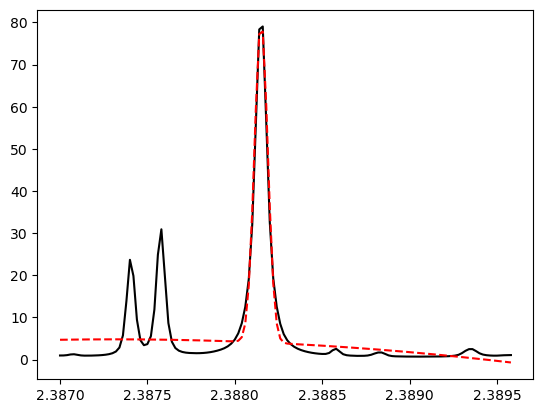

In [104]:
gemini_df = pd.read_csv('mk_skybg_zm_10_10_ph.dat', sep='\s+', header=None)
gemini_array = gemini_df.to_numpy()

wavelength = (gemini_array[74350:74480,0])/1000#[gemini_array[60500:62500,1]>0.5]
count = gemini_array[74350:74480,1]#[gemini_array[60500:62500,1]>0.5]

plt.figure()
plt.plot(wavelength, count, 'k', label='original')

# create lmfit model with defined gaussian
g1_model = Model(gaussian_fit)

# create parameters and add initial guess
g1_params = g1_model.make_params()
g1_params.add('a0', value=79, min=76, max=85)
g1_params.add('a1', value=2.3882)
g1_params.add('a2', value=0.003)
g1_params.add('a3', value=0)
g1_params.add('a4', value=0)
g1_params.add('a5', value=0)

g1_result = g1_model.fit(count, g1_params, x=wavelength)
# try:
#     g1_result = g1_model.fit(count, g1_params, x=wavelength)
# except:
#     pass

print(g1_result.fit_report(min_correl=0.25))

plt.plot(wavelength, g1_result.best_fit, 'r--', label='g1 best fit')
#plt.xlim(2.123,2.1235)

print(g1_result.params['a1'].value)

[[Model]]
    Model(gaussian_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 132
    # data points      = 130
    # variables        = 6
    chi-square         = 9128.98828
    reduced chi-square = 73.6208732
    Akaike info crit   = 564.717842
    Bayesian info crit = 581.923048
    R-squared          = 0.72956410
[[Variables]]
    a0:  92.0000254 +/- 6.32730345 (6.88%) (init = 97)
    a1:  2.40697823 +/- 2.9726e-06 (0.00%) (init = 2.407)
    a2:  0.00138474 +/- 7.3119e-05 (5.28%) (init = 0.003)
    a3:  63.5658015 +/- 8670693.46 (13640500.48%) (init = 0)
    a4:  0.80687644 +/- 7202509.65 (892640969.62%) (init = 0)
    a5: -10.3056534 +/- 1495732.19 (14513705.55%) (init = 0)
[[Correlations]] (unreported correlations are < 0.250)
    C(a4, a5) = -1.0000
    C(a3, a4) = -1.0000
    C(a3, a5) = +1.0000
    C(a0, a2) = -0.5775
    C(a0, a1) = +0.3606
    C(a1, a2) = -0.3062
2.4069782258240044


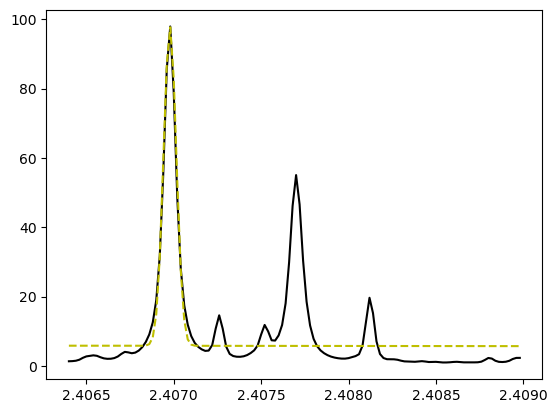

In [105]:
gemini_df = pd.read_csv('mk_skybg_zm_10_10_ph.dat', sep='\s+', header=None)
gemini_array = gemini_df.to_numpy()

wavelength = (gemini_array[75320:75450,0])/1000#[gemini_array[60500:62500,1]>0.5]
count = gemini_array[75320:75450,1]#[gemini_array[60500:62500,1]>0.5]
# count[count<30]=30

plt.figure()
plt.plot(wavelength, count, 'k', label='original')

# create lmfit model with defined gaussian
g2_model = Model(gaussian_fit)
#print('parameter names: {}'.format(g2model.param_names))
#print('independent variables: {}'.format(g2model.independent_vars))


# create parameters and add initial guess
g2_params = g2_model.make_params()
g2_params.add('a0', value=97, min=92)
g2_params.add('a1', value=2.4070)
g2_params.add('a2', value=0.003)
g2_params.add('a3', value=0)
g2_params.add('a4', value=0)
g2_params.add('a5', value=0)

try:
    g2_result = g2_model.fit(count, g2_params, x=wavelength)
except:
    pass

print(g2_result.fit_report(min_correl=0.25))

plt.plot(wavelength, g2_result.best_fit, 'y--', label='g2 best fit')
#plt.xlim(2.1246,2.1252)

print(g2_result.params['a1'].value)

[[Model]]
    Model(gaussian_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 132
    # data points      = 130
    # variables        = 6
    chi-square         = 9128.98828
    reduced chi-square = 73.6208732
    Akaike info crit   = 564.717842
    Bayesian info crit = 581.923048
    R-squared          = 0.72956410
[[Variables]]
    a0:  92.0000254 +/- 6.32730345 (6.88%) (init = 97)
    a1:  2.40697823 +/- 2.9726e-06 (0.00%) (init = 2.407)
    a2:  0.00138474 +/- 7.3119e-05 (5.28%) (init = 0.003)
    a3:  63.5658015 +/- 8670693.46 (13640500.48%) (init = 0)
    a4:  0.80687644 +/- 7202509.65 (892640969.62%) (init = 0)
    a5: -10.3056534 +/- 1495732.19 (14513705.55%) (init = 0)
[[Correlations]] (unreported correlations are < 0.250)
    C(a4, a5) = -1.0000
    C(a3, a4) = -1.0000
    C(a3, a5) = +1.0000
    C(a0, a2) = -0.5775
    C(a0, a1) = +0.3606
    C(a1, a2) = -0.3062
2.4069782258240044


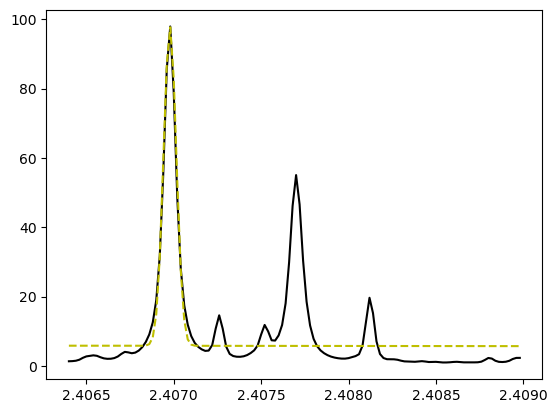

In [106]:
gemini_df = pd.read_csv('mk_skybg_zm_10_10_ph.dat', sep='\s+', header=None)
gemini_array = gemini_df.to_numpy()

wavelength = (gemini_array[75320:75450,0])/1000#[gemini_array[60500:62500,1]>0.5]
count = gemini_array[75320:75450,1]#[gemini_array[60500:62500,1]>0.5]
# count[count<30]=30

plt.figure()
plt.plot(wavelength, count, 'k', label='original')

# create lmfit model with defined gaussian
g2_model = Model(gaussian_fit)
#print('parameter names: {}'.format(g2model.param_names))
#print('independent variables: {}'.format(g2model.independent_vars))


# create parameters and add initial guess
g2_params = g2_model.make_params()
g2_params.add('a0', value=97, min=92)
g2_params.add('a1', value=2.4070)
g2_params.add('a2', value=0.003)
g2_params.add('a3', value=0)
g2_params.add('a4', value=0)
g2_params.add('a5', value=0)

try:
    g2_result = g2_model.fit(count, g2_params, x=wavelength)
except:
    pass

print(g2_result.fit_report(min_correl=0.25))

plt.plot(wavelength, g2_result.best_fit, 'y--', label='g2 best fit')
#plt.xlim(2.1246,2.1252)

print(g2_result.params['a1'].value)

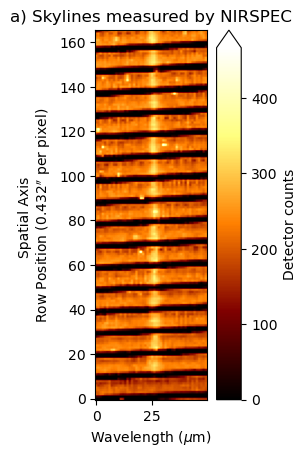

In [63]:
a = np.delete(skylines60p_shifted, np.s_[200:], 1)
b = np.delete(a, np.s_[:150], 1)

plt.figure()
plt.imshow(b, cmap='afmhot')
plt.xlabel(r'Wavelength ($\mu$m)')
plt.ylabel('Spatial Axis \nRow Position (0.432$^{\prime\prime}$ per pixel)')
plt.title('a) Skylines measured by NIRSPEC')
plt.gca().invert_yaxis()
plt.colorbar(extend='max', aspect=15, pad=0.02, label='Detector counts')

In [65]:
a = np.delete(skylines60p_shifted, np.s_[200:], 1)
b = np.delete(a, np.s_[:150], 1)
b = normalize(b)
# waveaxis = np.linspace(0, np.size(b, 1)-1, np.size(b, 1))
waveaxis = waverange[150:200]*100000

upper_skyline = 166
lower_skyline = 0

sky1_a1 = []
sky1_a1_pixel = []

for i in range(lower_skyline, upper_skyline):           
    if i%5 == 0 and i%10 != 0 and i!= 5:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=0.7, min=0.4, max=0.9)
        sky1_params.add('a1', value=238815)
#         sky1_params.add('a1', value=25)
        sky1_params.add('a2', value=5)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(b[i], sky1_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, b[i])
            plt.plot(waveaxis, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1.append(sky1_fit_result.params['a1'].value)
sky1_a1 = np.array(sky1_a1)/100000
# sky1_a1 = np.array(sky1_a1)+150

[[Model]]
    Model(constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 16
    # variables        = 1
    chi-square         = 4.5229e-09
    reduced chi-square = 3.0153e-10
    Akaike info crit   = -349.787240
    Bayesian info crit = -349.014652
    R-squared          = 0.00000000
[[Variables]]
    c:  2.38810096 +/- 4.3411e-06 (0.00%) (init = 2.388101)


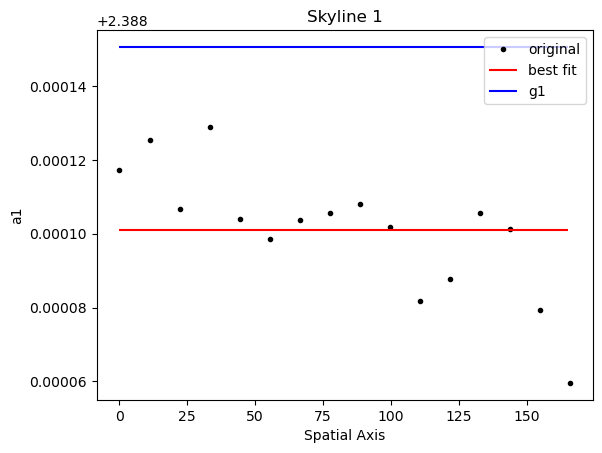

In [66]:
sky1_spat = np.linspace(lower_skyline, upper_skyline, len(sky1_a1))

x = sky1_spat
y = sky1_a1

mod = ConstantModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

sky1_spat_all = np.linspace(0, 165, 166)
# sky1_slope = out.params['slope'].value
# sky1_intercept = out.params['intercept'].value
sky1_c = out.params['c'].value
sky1_a1_best_fit = sky1_c

plt.plot(x, y, '.k', label = 'original')
plt.hlines(sky1_a1_best_fit, xmin=sky1_spat_all[0], xmax=sky1_spat_all[-1], color='r', label='best fit')
plt.hlines(g1_result.params['a1'].value, xmin=sky1_spat_all[0], xmax=sky1_spat_all[-1], color='b', label='g1')
plt.title('Skyline 1')
plt.xlabel('Spatial Axis')
plt.ylabel('a1')
plt.legend()

In [67]:
g1_result.params['a1'].value - sky1_a1_best_fit

4.9631629534196975e-05

In [68]:
a = np.delete(skylines60p_shifted, np.s_[200:], 1)
b = np.delete(a, np.s_[:150], 1)
b = normalize(b)
waveaxis = np.linspace(0, np.size(b, 1)-1, np.size(b, 1))
# waveaxis = waverange[150:200]*100000

upper_skyline = 166
lower_skyline = 0

sky1_a1 = []
sky1_a1_pixel = []

for i in range(lower_skyline, upper_skyline):           
    if i%5 == 0 and i%10 != 0 and i!= 5:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=0.7, min=0.4, max=0.9)
#         sky1_params.add('a1', value=238815)
        sky1_params.add('a1', value=25, min=24)
        sky1_params.add('a2', value=5)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(b[i], sky1_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, b[i])
            plt.plot(waveaxis, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1.append(sky1_fit_result.params['a1'].value)
# sky1_a1 = np.array(sky1_a1)/100000
sky1_a1 = np.array(sky1_a1)+150

[[Model]]
    Model(constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 16
    # variables        = 1
    chi-square         = 7.61958681
    reduced chi-square = 0.50797245
    Akaike info crit   = -9.86986526
    Bayesian info crit = -9.09727653
    R-squared          = 0.00000000
[[Variables]]
    c:  175.220616 +/- 0.17818047 (0.10%) (init = 175.2206)


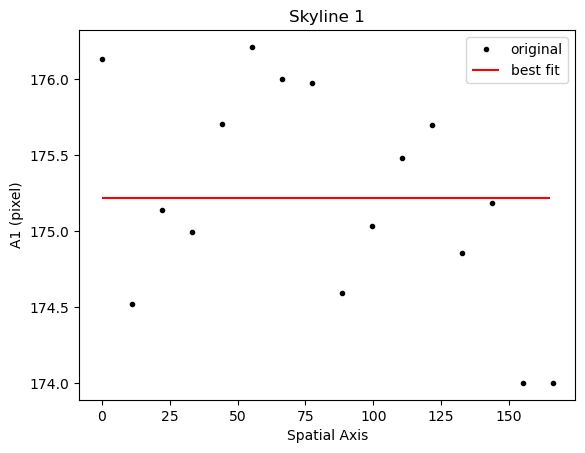

In [69]:
sky1_spat = np.linspace(lower_skyline, upper_skyline, len(sky1_a1))
x = sky1_spat
y = sky1_a1

mod = ConstantModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

sky1_spat_all = np.linspace(0, 165, 166)
sky1_c = out.params['c'].value
sky1_pixel_best_fit = sky1_c

plt.figure()
plt.plot(x, y, '.k', label = 'original')
plt.hlines(sky1_pixel_best_fit, xmin=sky1_spat_all[0], xmax=sky1_spat_all[-1], color='r', label='best fit')
plt.xlabel('spatial axis')
plt.ylabel('a1')
plt.ticklabel_format(useOffset=False)
plt.title('Skyline 1')
plt.xlabel('Spatial Axis')
plt.ylabel('A1 (pixel)')
plt.legend()

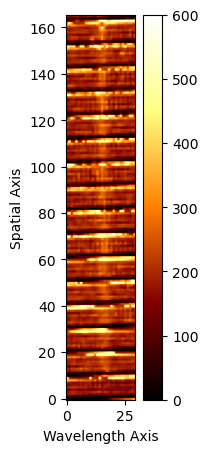

In [70]:
c = np.delete(skylines60p_shifted, np.s_[760:], 1)
d = np.delete(c, np.s_[:730], 1)

plt.figure(figsize=(2,5))
# plt.imshow(c, aspect='auto', extent=[waverange[120], waverange[179], 364, 225], cmap='afmhot')
plt.imshow(d, cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()
plt.colorbar()

Error occured at i=135


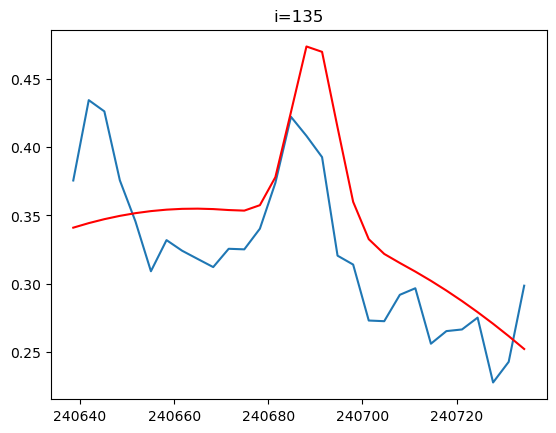

In [71]:
c = np.delete(skylines60p_shifted, np.s_[760:], 1)
d = np.delete(c, np.s_[:730], 1)
d = normalize(d)
#waveaxis = np.linspace(0, np.size(e, 1), np.size(e, 1))
waveaxis = waverange[730:760]*100000

upper_skyline = 160
lower_skyline = 0

sky2_a1 = []

for i in range(lower_skyline, upper_skyline):           
    if i%5 == 0 and i%10 != 0 and i!= 5:
        # create lmfit model with defined gaussian
        sky2_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky2_params = sky2_model.make_params()
        sky2_params.add('a0', value=0.5)
        sky2_params.add('a1', value=240698, min=240680, max=240710)
        sky2_params.add('a2', value=5)
        sky2_params.add('a3', value=0.3)
        sky2_params.add('a4', value=0)
        sky2_params.add('a5', value=0)
    
        try:
            sky2_fit_result = sky2_model.fit(d[i], sky2_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky2_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, d[i])
            plt.plot(waveaxis, sky2_fit_result.best_fit, 'r-', label='best fit')
            
        sky2_a1.append(sky2_fit_result.params['a1'].value)
sky2_a1 = np.array(sky2_a1)/100000

[[Model]]
    Model(constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 15
    # variables        = 1
    chi-square         = 2.9609e-08
    reduced chi-square = 2.1149e-09
    Akaike info crit   = -298.648458
    Bayesian info crit = -297.940408
    R-squared          = 2.2204e-16
[[Variables]]
    c:  2.40688092 +/- 1.1874e-05 (0.00%) (init = 2.406881)


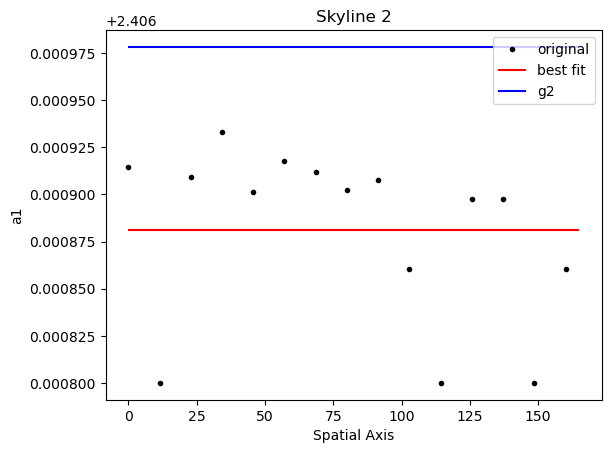

In [72]:
sky2_spat = np.linspace(lower_skyline, upper_skyline, len(sky2_a1))

x = sky2_spat
y = sky2_a1

mod = ConstantModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

sky2_spat_all = np.linspace(0, 165, 166)
# sky2_slope = out.params['slope'].value
# sky2_intercept = out.params['intercept'].value
sky2_c = out.params['c'].value
sky2_a1_best_fit = sky2_c

plt.plot(x, y, '.k', label = 'original')
plt.hlines(sky2_a1_best_fit, xmin=sky2_spat_all[0], xmax=sky2_spat_all[-1], color='r', label='best fit')
plt.hlines(g2_result.params['a1'].value, xmin=sky2_spat_all[0], xmax=sky2_spat_all[-1], color='b', label='g2')
plt.title('Skyline 2')
plt.xlabel('Spatial Axis')
plt.ylabel('a1')
plt.legend()

In [74]:
g2_result.params['a1'].value - sky2_a1_best_fit

9.730263919749405e-05

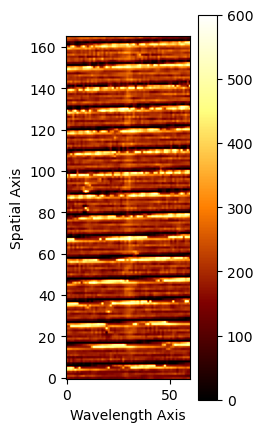

In [107]:
e = np.delete(skylines60p_shifted, np.s_[1000:], 1)
f = np.delete(e, np.s_[:940], 1)

plt.figure(figsize=(2,5))
# plt.imshow(c, aspect='auto', extent=[waverange[120], waverange[179], 364, 225], cmap='afmhot')
plt.imshow(f, cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()
plt.colorbar()

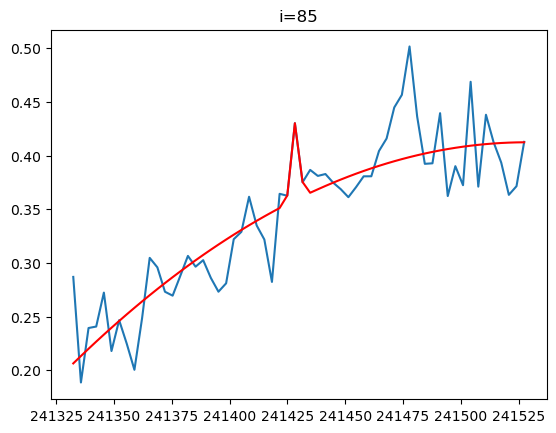

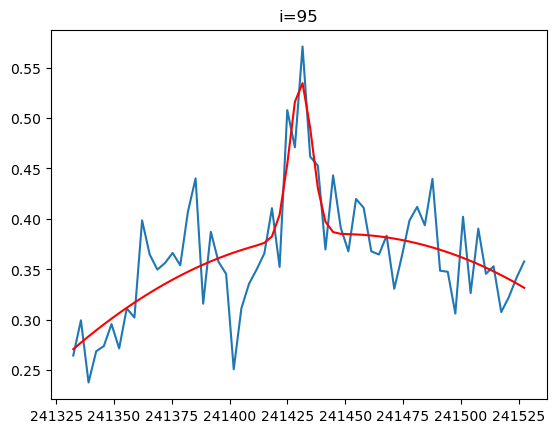

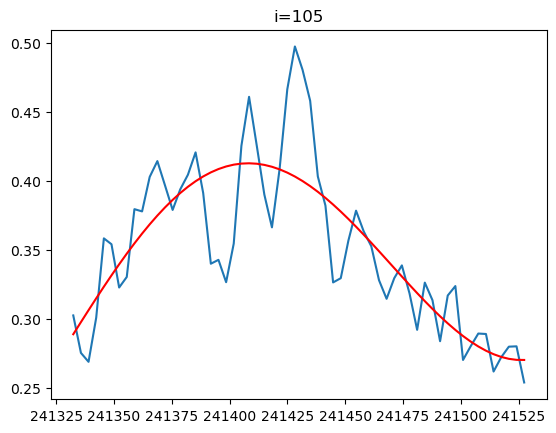

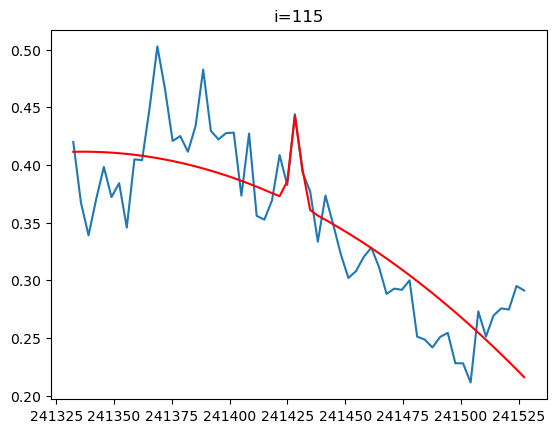

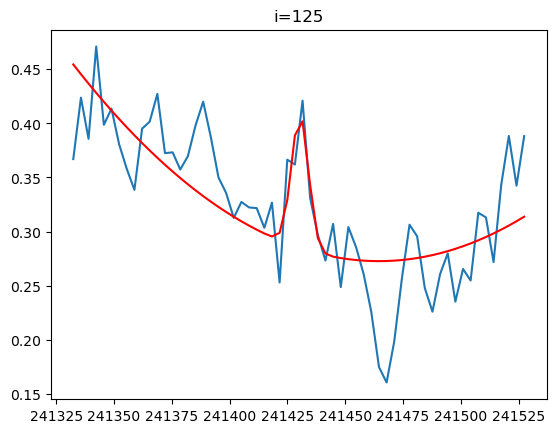

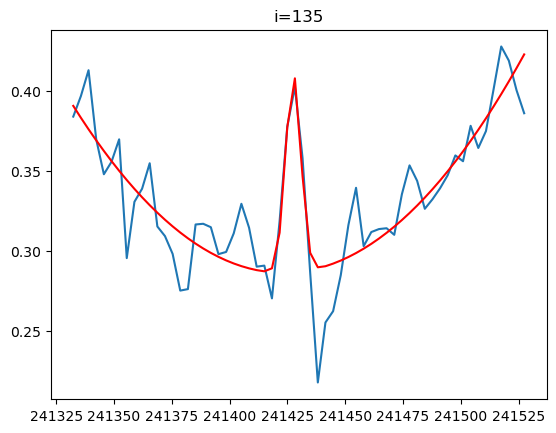

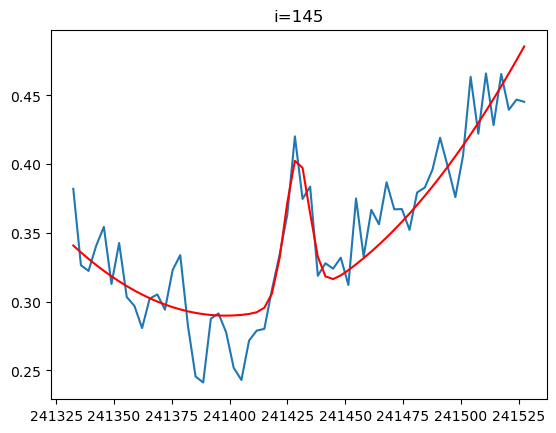

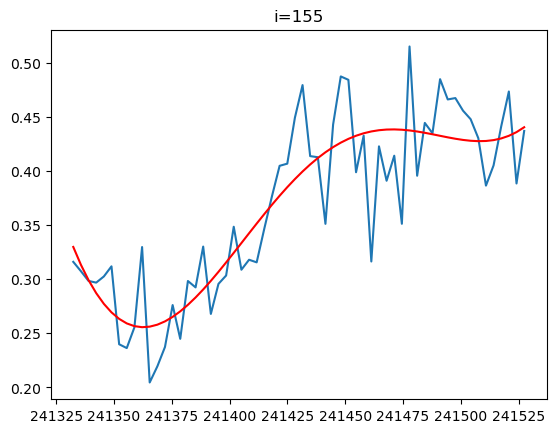

In [108]:
e = np.delete(skylines60p_shifted, np.s_[1000:], 1)
f = np.delete(e, np.s_[:940], 1)
f = normalize(f)
#waveaxis = np.linspace(0, np.size(e, 1), np.size(e, 1))
waveaxis = waverange[940:1000]*100000

upper_skyline = 160
lower_skyline = 0

sky3_a1 = []

for i in range(80):           
    if i%10 == 0 and i != 0:
        # create lmfit model with defined gaussian
        sky3_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky3_params = sky3_model.make_params()
        sky3_params.add('a0', value=0.5)
        sky3_params.add('a1', value=241433)
        sky3_params.add('a2', value=5)
        sky3_params.add('a3', value=0.3)
        sky3_params.add('a4', value=0)
        sky3_params.add('a5', value=0)
    
        try:
            sky3_fit_result = sky3_model.fit(f[i], sky3_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky3_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, f[i])
            plt.plot(waveaxis, sky3_fit_result.best_fit, 'r-', label='best fit')
            
        sky3_a1.append(sky3_fit_result.params['a1'].value)
        
for i in range(85, 160):           
    if i%5 == 0 and i%2 !=0:
        # create lmfit model with defined gaussian
        sky3_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky3_params = sky3_model.make_params()
        sky3_params.add('a0', value=0.5)
        sky3_params.add('a1', value=241430, min=241400, max=241450)
        sky3_params.add('a2', value=1)
        sky3_params.add('a3', value=0)
        sky3_params.add('a4', value=0)
        sky3_params.add('a5', value=0)
    
        try:
            sky3_fit_result = sky3_model.fit(f[i], sky3_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky3_fit_result.fit_report())
        plt.figure()
        plt.title('i='+str(i))
        plt.plot(waveaxis, f[i])
        plt.plot(waveaxis, sky3_fit_result.best_fit, 'r-', label='best fit')
            
        sky3_a1.append(sky3_fit_result.params['a1'].value)
        
sky3_a1 = np.array(sky3_a1)/100000

[[Model]]
    Model(constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 15
    # variables        = 1
    chi-square         = 1.9105e-07
    reduced chi-square = 1.3647e-08
    Akaike info crit   = -270.681447
    Bayesian info crit = -269.973396
    R-squared          = 0.00000000
[[Variables]]
    c:  2.41427693 +/- 3.0163e-05 (0.00%) (init = 2.414277)


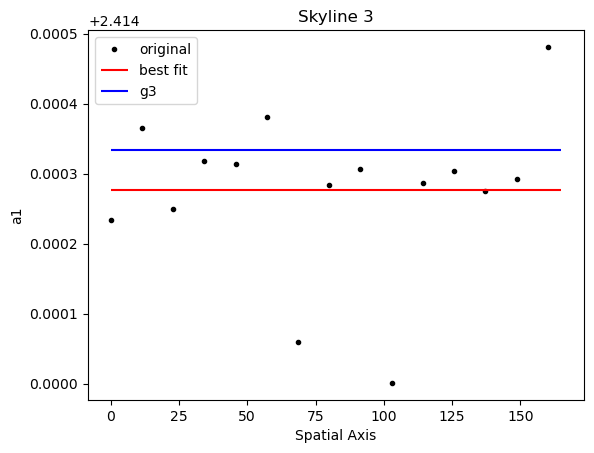

In [109]:
sky3_spat = np.linspace(lower_skyline, upper_skyline, len(sky3_a1))

x = sky3_spat
y = sky3_a1

mod = ConstantModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

sky3_spat_all = np.linspace(0, 165, 166)
# sky3_slope = out.params['slope'].value
# sky3_intercept = out.params['intercept'].value
sky3_c = out.params['c'].value
sky3_a1_best_fit = sky3_c

plt.plot(x, y, '.k', label = 'original')
plt.hlines(sky3_a1_best_fit, xmin=sky3_spat_all[0], xmax=sky3_spat_all[-1], color='r', label='best fit')
plt.hlines(g3_result.params['a1'].value, xmin=sky3_spat_all[0], xmax=sky3_spat_all[-1], color='b', label='g3')
plt.title('Skyline 3')
plt.xlabel('Spatial Axis')
plt.ylabel('a1')
plt.legend()

In [110]:
g3_result.params['a1'].value - sky3_a1_best_fit

5.6473827811043265e-05

In [111]:
e = np.delete(skylines60p_shifted, np.s_[1000:], 1)
f = np.delete(e, np.s_[:940], 1)
f = normalize(f)
waveaxis = np.linspace(0, np.size(f,1)-1, np.size(f,1))
# waveaxis = waverange[940:1000]*100000

upper_skyline = 160
lower_skyline = 0

sky3_a1 = []

for i in range(80):           
    if i%10 == 0 and i != 0:
        # create lmfit model with defined gaussian
        sky3_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky3_params = sky3_model.make_params()
        sky3_params.add('a0', value=0.5)
        sky3_params.add('a1', value=30, min=25, max=35)
#         sky3_params.add('a1', value=241433)
        sky3_params.add('a2', value=5)
        sky3_params.add('a3', value=0.3)
        sky3_params.add('a4', value=0)
        sky3_params.add('a5', value=0)
    
        try:
            sky3_fit_result = sky3_model.fit(f[i], sky3_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky3_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, f[i])
            plt.plot(waveaxis, sky3_fit_result.best_fit, 'r-', label='best fit')
            
        sky3_a1.append(sky3_fit_result.params['a1'].value)
        
for i in range(85, 160):           
    if i%5 == 0 and i%2 !=0:
        # create lmfit model with defined gaussian
        sky3_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky3_params = sky3_model.make_params()
        sky3_params.add('a0', value=0.5)
        sky3_params.add('a1', value=30, min=25, max=35)
#         sky3_params.add('a1', value=241433)
        sky3_params.add('a2', value=5)
        sky3_params.add('a3', value=0.3)
        sky3_params.add('a4', value=0)
        sky3_params.add('a5', value=0)
    
        try:
            sky3_fit_result = sky3_model.fit(f[i], sky3_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky3_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, f[i])
            plt.plot(waveaxis, sky3_fit_result.best_fit, 'r-', label='best fit')
            
        sky3_a1.append(sky3_fit_result.params['a1'].value)
        
# sky3_a1 = np.array(sky3_a1)/100000
sky3_a1 = np.array(sky3_a1)+940

[[Model]]
    Model(constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 15
    # variables        = 1
    chi-square         = 190.804731
    reduced chi-square = 13.6289094
    Akaike info crit   = 40.1480053
    Bayesian info crit = 40.8560555
    R-squared          = 1.1102e-16
[[Variables]]
    c:  970.054928 +/- 0.95320195 (0.10%) (init = 970.0549)


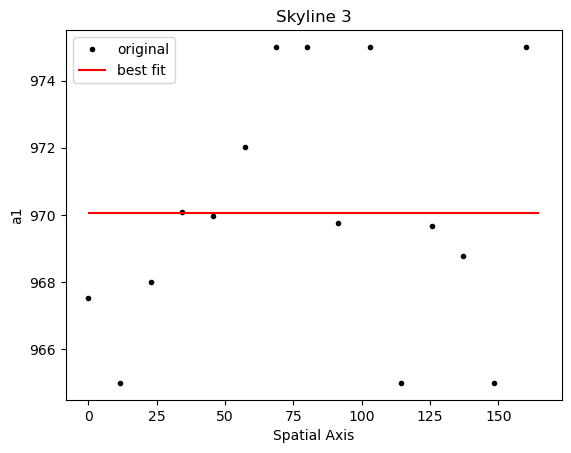

In [112]:
sky1_spat = np.linspace(lower_skyline, upper_skyline, len(sky1_a1))

x = sky3_spat
y = sky3_a1

mod = ConstantModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

sky3_spat_all = np.linspace(0, 165, 166)
sky3_c = out.params['c'].value
sky3_pixel_best_fit = sky3_c

plt.plot(x, y, '.k', label = 'original')
plt.hlines(sky3_pixel_best_fit, xmin=sky3_spat_all[0], xmax=sky3_spat_all[-1], color='r', label='best fit')
# plt.hlines(g3_result.params['a1'].value, xmin=sky3_spat_all[0], xmax=sky3_spat_all[-1], color='b', label='g3')
plt.title('Skyline 3')
plt.xlabel('Spatial Axis')
plt.ylabel('a1')
plt.legend()

In [113]:
print(sky1_pixel_best_fit)
print(sky3_pixel_best_fit)
print(sky1_a1_best_fit)
print(sky3_a1_best_fit)

R = (sky1_a1_best_fit + sky3_a1_best_fit)*0.5/((sky3_a1_best_fit - sky1_a1_best_fit)/(sky3_pixel_best_fit - sky1_pixel_best_fit))
R

175.2206159945751
970.0549277716417
2.388100959329023
2.4142769257342898


72912.20240104834